# Table of categories

In [48]:
import pandas as pd

train_data = pd.read_csv('processed_data/train_trans.csv')
texts_train, targets_train = train_data.text, train_data.target
val_data = pd.read_csv('processed_data/val_trans.csv')
texts_val, targets_val = val_data.text, val_data.target

pd.DataFrame({'train': targets_train.value_counts(), 'val': targets_val.value_counts()}).sort_values('train', ascending=False)

,train,val
3,19535,2171
25,17718,1969
21,11615,1291
36,10479,1164
14,7065,785
6,5784,643
12,5737,637
19,5264,585
5,5253,584
2,4126,458


# RF predicts

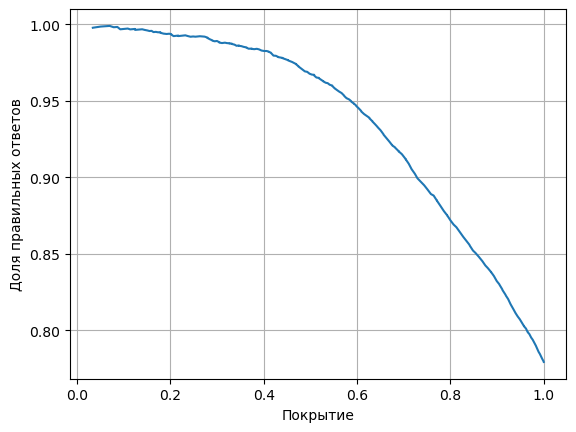

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('rf_predicts.csv')
c_all, a_all, t_all = [], [], []
for thr in sorted(data.proba.unique(), reverse=True):
    good = data[data.proba >= thr]
    a_all += [(good.target == good.predict).mean()]
    c_all += [len(good) / len(data)]
    t_all += [thr]
plt.plot(c_all, a_all)
plt.xlabel('Покрытие')
plt.ylabel('Доля правильных ответов')
plt.grid()

In [7]:
# common f_score
fac = []
for a, c in zip(a_all, c_all):
    f = 2*a*c/(a+c)
    fac += [(f, a, c)]
sorted(fac, reverse=True)[:10]

[(0.8760192862258466, 0.7799938865963625, 0.9990075578288419),
 (0.8760110426477119, 0.7799342859326048, 0.9990838995343156),
 (0.876009117176558, 0.7821319018404908, 0.9954958393770517),
 (0.8760051395623114, 0.7804374426430101, 0.998244140774105),
 (0.8760010517137304, 0.7820719269994633, 0.9955721810825254),
 (0.8759828336288912, 0.7845099699745939, 0.9916024123978929),
 (0.8759749679462479, 0.7844495765973826, 0.9916787541033667),
 (0.875954312209972, 0.7897515527950311, 0.9832811665012596),
 (0.8759532164460955, 0.779517336184512, 0.9996182914726315),
 (0.8759505610670555, 0.7845537845537846, 0.9914497289869456)]

In [8]:
# new f_score
fac = []
for a, c in zip(a_all, c_all):
    f = 8*a*c/(a+7*c)
    fac += [(f, a, c)]
sorted(fac, reverse=True)[:10]

[(0.8836895807183789, 0.9389024390243902, 0.6260019848843423),
 (0.883570464145631, 0.9367378968972594, 0.6323383464386595),
 (0.8835501235434354, 0.9386734942696903, 0.6261546682952898),
 (0.8835256364949192, 0.9366324683162341, 0.6324910298496068),
 (0.8835097011629982, 0.9364447660395562, 0.6330254217879228),
 (0.8835052024293946, 0.9385665529010239, 0.6263073517062371),
 (0.883501058223912, 0.936624818928054, 0.6324146881441332),
 (0.8834808165628466, 0.9365270906238687, 0.6326437132605542),
 (0.8834804045111615, 0.938559063757162, 0.6262310100007634),
 (0.8834705540761448, 0.9346241185610135, 0.6387510496984503)]

In [3]:
import optuna

thrs = data.groupby('predict').proba.agg(lambda d: list(set(d)))
classes = data.predict.unique()

def objective(trial):
    good = data.copy()
    for i in classes:
        trial.suggest_float(f'thr_{i}', 0, 1)
        good = good[(good.predict != i) | (good.proba >= trial.params[f'thr_{i}'])]
    acc = (good.target == good.predict).mean()
    cover = len(good) / len(data)
    f_score = 8 * acc * cover / (acc + 7 * cover)
    return f_score

study = optuna.create_study(direction='maximize')
study.optimize(objective, timeout=300, n_jobs=-1)

[I 2023-06-03 15:08:19,692] A new study created in memory with name: no-name-9359e5b5-72ba-4688-a6e1-cf026dc74c89
[I 2023-06-03 15:08:21,126] Trial 1 finished with value: 0.8082935792680966 and parameters: {'thr_21': 0.546834876679402, 'thr_25': 0.549555032901635, 'thr_3': 0.8994551580509358, 'thr_36': 0.8729569033915742, 'thr_5': 0.7535648340572769, 'thr_14': 0.308677802315507, 'thr_28': 0.3628422225340694, 'thr_2': 0.06682736887738716, 'thr_32': 0.8321866666759747, 'thr_19': 0.46016979150657666, 'thr_37': 0.7248325032029778, 'thr_12': 0.8166994372710499, 'thr_22': 0.11595740328665127, 'thr_17': 0.24948802549983606, 'thr_16': 0.7690277262047235, 'thr_6': 0.8970384098621209, 'thr_4': 0.751643510218719, 'thr_26': 0.5842002900948836, 'thr_9': 0.6611707668893823, 'thr_10': 0.4264455137623635, 'thr_0': 0.08830720218288746, 'thr_24': 0.0827731669590347, 'thr_18': 0.6586026659715167, 'thr_33': 0.41406082175293446, 'thr_35': 0.5847656752418503, 'thr_8': 0.0841243363982529, 'thr_27': 0.9480211

In [4]:
good = data.copy()
for i in classes:
    thr_i = study.best_params[f'thr_{i}']
    good = good[(good.predict != i) | (good.proba >= thr_i)]
acc = (good.target == good.predict).mean()
cover = len(good) / len(data)
f_score = 8 * acc * cover / (acc + 7 * cover)
acc, cover, f_score

(0.9391883851005594, 0.6414993510955035, 0.8876962372692101)

In [5]:
from math import log10
data.groupby('target').text.count().apply(log10).sum()

73.642751223939

In [5]:
import optuna

classes = data.predict.unique()
separate_classes = [3, 25, 21, 36]

def objective(trial):
    good = data.copy()

    for i in separate_classes:
        trial.suggest_float(f'thr_{i}', 0, 1)
        good = good[(good.predict != i) | (good.proba >= trial.params[f'thr_{i}'])]

    trial.suggest_float('thr_other', 0, 1)
    good = good[good.predict.isin(separate_classes) | (good.proba >= trial.params['thr_other'])]

    acc = (good.target == good.predict).mean()
    cover = len(good) / len(data)
    f_score = 8 * acc * cover / (acc + 7 * cover)
    return f_score

study2 = optuna.create_study(direction='maximize')
study2.optimize(objective, timeout=300, n_jobs=-1)

[I 2023-06-03 15:14:55,551] A new study created in memory with name: no-name-e3cae63d-d356-4d9c-b96e-4b2a78de8ef1
[I 2023-06-03 15:14:55,655] Trial 0 finished with value: 0.84680788936234 and parameters: {'thr_3': 0.5626625084885121, 'thr_25': 0.40772727029654976, 'thr_21': 0.9740496747483757, 'thr_36': 0.14661623213878783, 'thr_other': 0.4737642811193974}. Best is trial 0 with value: 0.84680788936234.
[I 2023-06-03 15:14:55,665] Trial 1 finished with value: 0.8531769801222109 and parameters: {'thr_3': 0.662546410264798, 'thr_25': 0.4598310087114865, 'thr_21': 0.012519624623541947, 'thr_36': 0.8192244556365708, 'thr_other': 0.45684105640482897}. Best is trial 1 with value: 0.8531769801222109.
[I 2023-06-03 15:14:55,686] Trial 2 finished with value: 0.8503837218488562 and parameters: {'thr_3': 0.7860093988252304, 'thr_25': 0.44850398998848306, 'thr_21': 0.007210320690757888, 'thr_36': 0.3171005301419698, 'thr_other': 0.520706905694246}. Best is trial 1 with value: 0.8531769801222109.
[I

In [6]:
good = data.copy()
for i in separate_classes:
    thr_i = study2.best_params[f'thr_{i}']
    good = good[(good.predict != i) | (good.proba >= thr_i)]
good = good[good.predict.isin(separate_classes) | (good.proba >= study2.best_params['thr_other'])]
acc2 = (good.target == good.predict).mean()
cover2 = len(good) / len(data)
f_score2 = 8 * acc2 * cover2 / (acc2 + 7 * cover2)
acc2, cover2, f_score2

(0.9309457190822608, 0.682113138407512, 0.8903463017208236)

In [7]:
classes = data.predict.unique()
separate_classes = [3, 25, 21, 36, 14, 6, 12]

def objective(trial):
    good = data.copy()

    for i in separate_classes:
        trial.suggest_float(f'thr_{i}', 0, 1)
        good = good[(good.predict != i) | (good.proba >= trial.params[f'thr_{i}'])]

    trial.suggest_float('thr_other', 0, 1)
    good = good[good.predict.isin(separate_classes) | (good.proba >= trial.params['thr_other'])]

    acc = (good.target == good.predict).mean()
    cover = len(good) / len(data)
    f_score = 8 * acc * cover / (acc + 7 * cover)
    return f_score

study3 = optuna.create_study(direction='maximize')
study3.optimize(objective, timeout=300, n_jobs=-1)

[I 2023-06-03 15:22:54,451] A new study created in memory with name: no-name-336e2d93-79f3-44d3-911c-862d470a57a1
[I 2023-06-03 15:22:54,731] Trial 0 finished with value: 0.8453999166553955 and parameters: {'thr_3': 0.39120389554927304, 'thr_25': 0.412890520288542, 'thr_21': 0.7691523400282086, 'thr_36': 0.5993477867867505, 'thr_14': 0.3552226593356641, 'thr_6': 0.36621531231408044, 'thr_12': 0.4335775622827608, 'thr_other': 0.712586105387371}. Best is trial 0 with value: 0.8453999166553955.
[I 2023-06-03 15:22:54,777] Trial 6 finished with value: 0.8169262674517646 and parameters: {'thr_3': 0.5905614428160019, 'thr_25': 0.7510747952408977, 'thr_21': 0.8959441614938477, 'thr_36': 0.25956153549143257, 'thr_14': 0.4121927109028707, 'thr_6': 0.31332839262532775, 'thr_12': 0.1479421771718621, 'thr_other': 0.9349760736897161}. Best is trial 0 with value: 0.8453999166553955.
[I 2023-06-03 15:22:54,781] Trial 1 finished with value: 0.7881627738036012 and parameters: {'thr_3': 0.03530887032685

In [9]:
good = data.copy()
for i in separate_classes:
    thr_i = study3.best_params[f'thr_{i}']
    good = good[(good.predict != i) | (good.proba >= thr_i)]
good = good[good.predict.isin(separate_classes) | (good.proba >= study3.best_params['thr_other'])]
acc3 = (good.target == good.predict).mean()
cover3 = len(good) / len(data)
f_score3 = 8 * acc3 * cover3 / (acc3 + 7 * cover3)
acc3, cover3, f_score3

(0.9297170862107373, 0.6853958317428811, 0.8900575271796944)

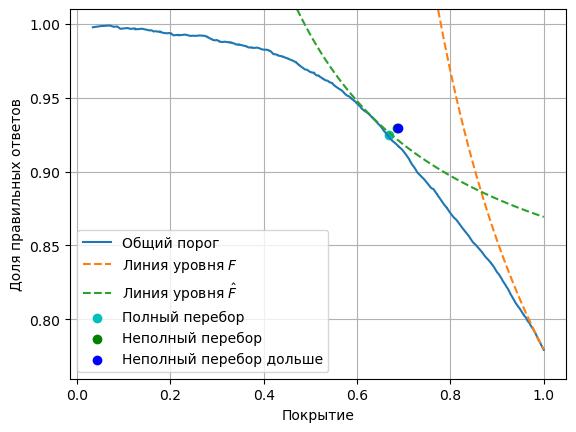

In [17]:
plt.plot(c_all, a_all, label='Общий порог')
x_grid = np.linspace(0.4, 1, 100)
y_grid = 7*k*x_grid/(8*x_grid-k)
x_grid2 = np.linspace(0.7, 1, 100)
y_grid2 = k2*x_grid2/(2*x_grid2-k2)
plt.plot(x_grid2, y_grid2, '--', label='Линия уровня $F$')
plt.plot(x_grid, y_grid, '--', label='Линия уровня $\hat{F}$')
plt.scatter(cover, acc, c='c', label='Полный перебор')
plt.scatter(cover2, acc2, c='g', label='Неполный перебор')
plt.scatter(cover3, acc3, c='b', label='Неполный перебор дольше')
plt.xlabel('Покрытие')
plt.ylabel('Доля правильных ответов')
plt.ylim(top=1.01)
plt.grid()
plt.legend();